In [1]:
!pip install git+https://github.com/imanring/BSTPP.git

  Cloning https://github.com/imanring/BSTPP.git to /tmp/pip-req-build-4bsvyi4m
  Running command git clone --filter=blob:none --quiet https://github.com/imanring/BSTPP.git /tmp/pip-req-build-4bsvyi4m
  Resolved https://github.com/imanring/BSTPP.git to commit b32ace1a87699ad54752e96b0ecf2bb84e272307
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for BSTPP, since package 'wheel' is not installed.
  Running setup.py install for BSTPP ... done


In [1]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np

In [2]:
import geopandas as gpd
A = gpd.read_file('data/Chicago/Boundaries - Community Areas (current).zip')

In [12]:
#A = np.array([[-87.940114,-87.524137],
#              [41.644543,42.023039]])
column_names = ['POP_DENS','VAC_HU','HH_SIZE']
model_name = 'cox_hawkes'
model = Point_Process_Model('data/Chicago/Crime_Incident_Reports/sr_2022_xyt.csv',A,model=model_name,
                            spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(1,5), alpha = dist.Beta(1,1)
                           )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:70: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:181: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

In [ ]:
model.run_mcmc()

warmup:   2%|▌                             | 25/1500 [00:20<28:44,  1.17s/it, 31 steps of size 2.36e-02. acc. prob=0.72]

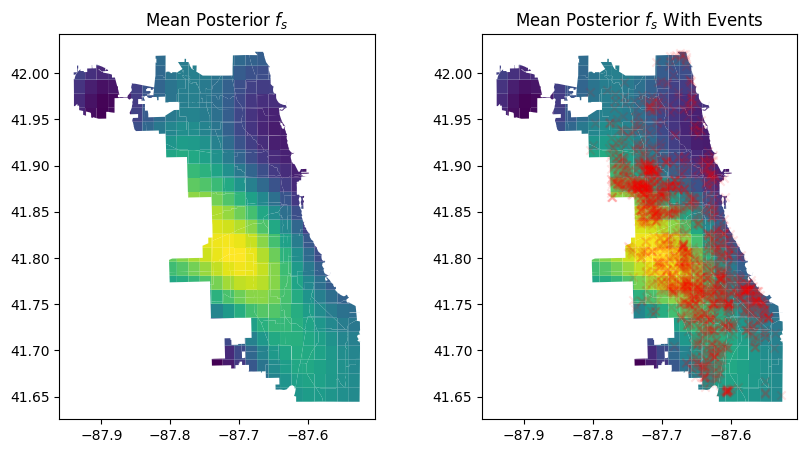

In [14]:
model.plot_spatial_background()

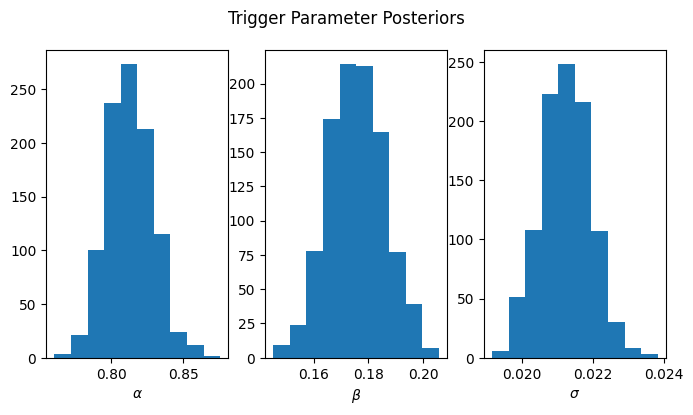

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.812942,0.016099,50.497414,0.0,0.783941,0.845819
beta,0.175624,0.010131,17.335905,0.0,0.156024,0.195538
sigma,0.021241,0.000697,30.479815,0.0,0.019871,0.022640


In [15]:
model.plot_trigger_posterior()

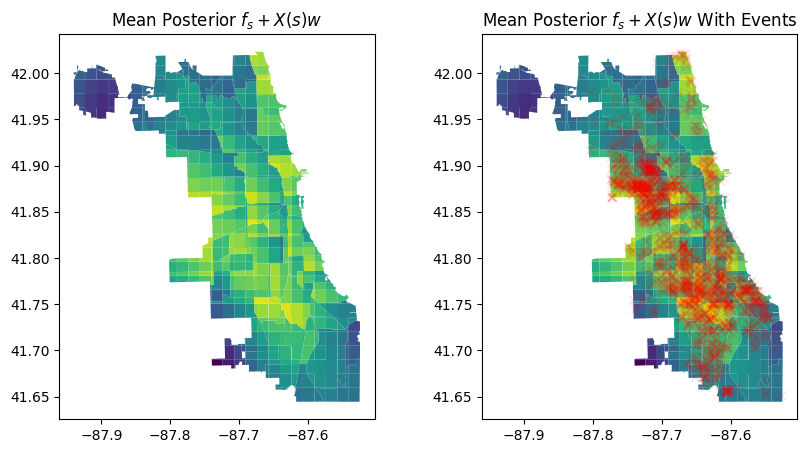

In [16]:
model.plot_spatial_background(include_cov=True)

In [7]:
ss_mod = Point_Process_Model('data/Chicago/ShotSpotter/ss_2022_xyt.csv',A,model=model_name,
                            spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:178: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


In [15]:
model.run_mcmc(output_file=f'output/Chicago_Shootings/{model_name}/output.pkl')

sample: 100%|█████████████████████████████| 1500/1500 [05:26<00:00,  4.59it/s, 7 steps of size 5.03e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_0      3.05      0.06      3.05      2.96      3.14    383.32      1.00
     alpha      0.97      0.02      0.97      0.94      1.00    395.31      1.00
      beta      0.11      0.01      0.11      0.10      0.12    332.92      1.00
  sigmax_2      0.00      0.00      0.00      0.00      0.00    318.37      1.00

Number of divergences: 0

MCMC elapsed time: 333.8766505718231


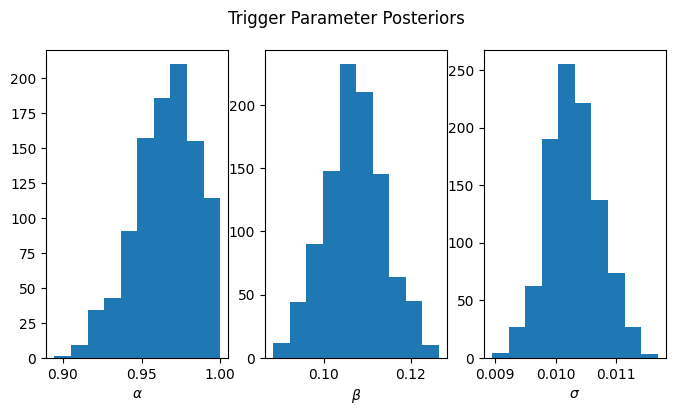

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.965308,0.019696,49.011559,0.0,0.92211,0.997130
beta,0.107085,0.006759,15.843665,0.0,0.09410,0.120675
sigma,0.010306,0.000425,24.255939,0.0,0.00948,0.011176


In [16]:
model.plot_trigger_posterior()

(array([  4.,  20.,  60., 142., 224., 242., 185.,  95.,  25.,   3.]),
 array([2.859296 , 2.896313 , 2.93333  , 2.970347 , 3.007364 , 3.044381 ,
        3.0813978, 3.1184149, 3.1554317, 3.1924489, 3.2294657],
       dtype=float32),
 <BarContainer object of 10 artists>)

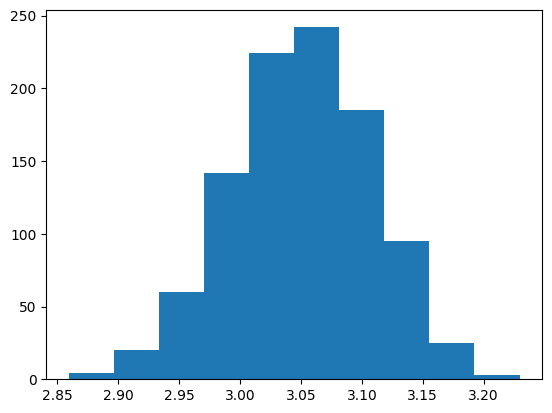

In [17]:
import matplotlib.pyplot as plt
plt.hist(model.mcmc_samples['a_0'])

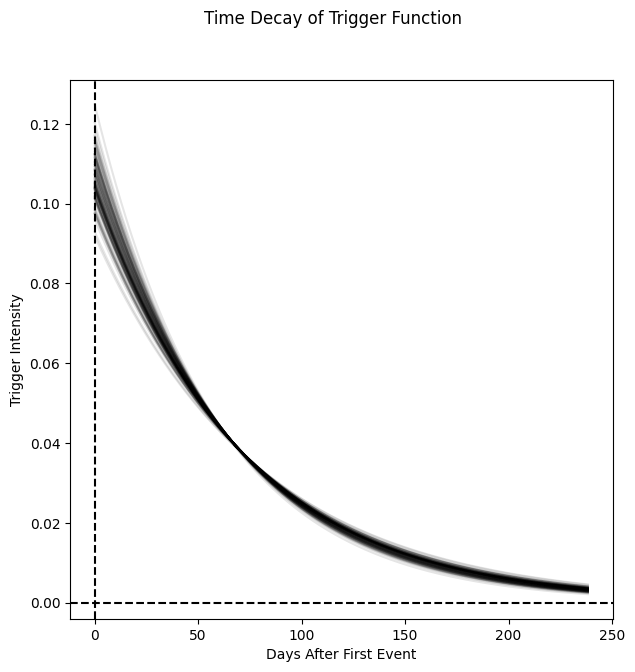

Mean trigger time: 68.09 days


In [18]:
model.plot_trigger_time_decay()

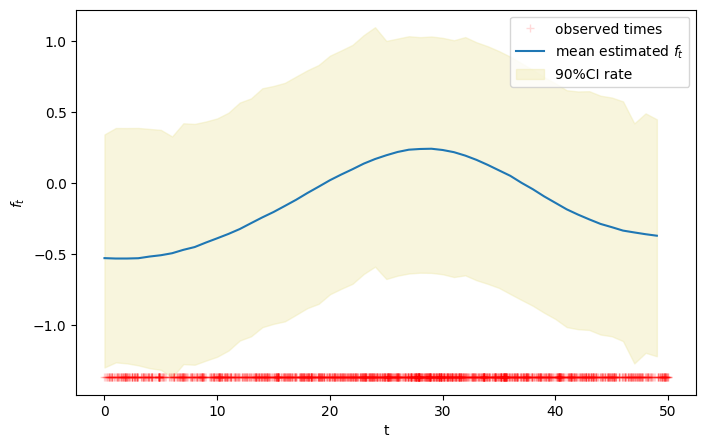

In [15]:
model.plot_temporal_background()

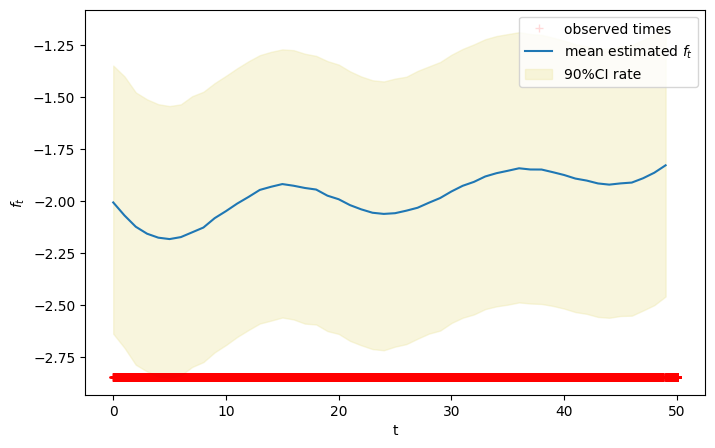

In [16]:
ss_mod.plot_temporal_background()

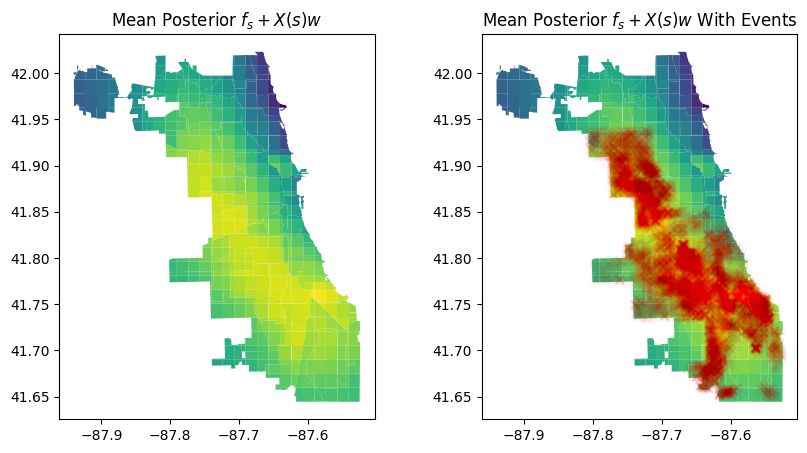

In [12]:
ss_mod.plot_spatial_background(alpha=0.01,include_cov=True)

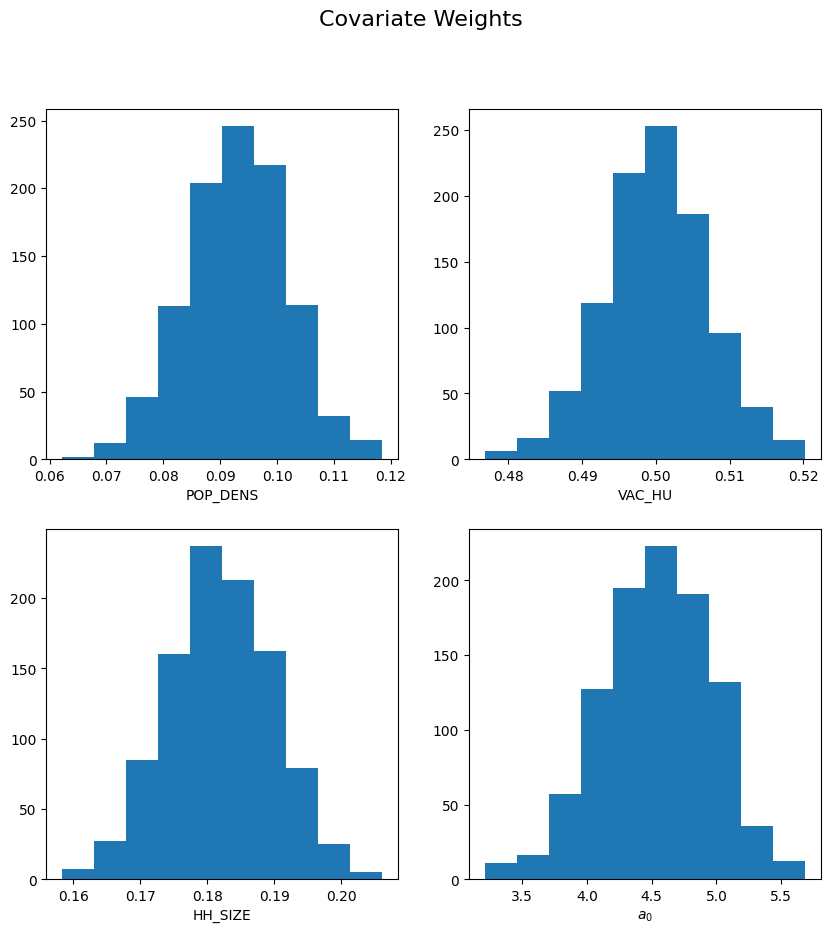

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,0.093051,0.008839,10.526770,0.0,0.075580,0.109942
VAC_HU,0.500102,0.007052,70.916290,0.0,0.486157,0.514298
HH_SIZE,0.182037,0.007836,23.231586,0.0,0.167092,0.197013
a_0,4.541831,0.418949,10.841018,0.0,3.685917,5.291924


In [13]:
ss_mod.cov_weight_post_summary()

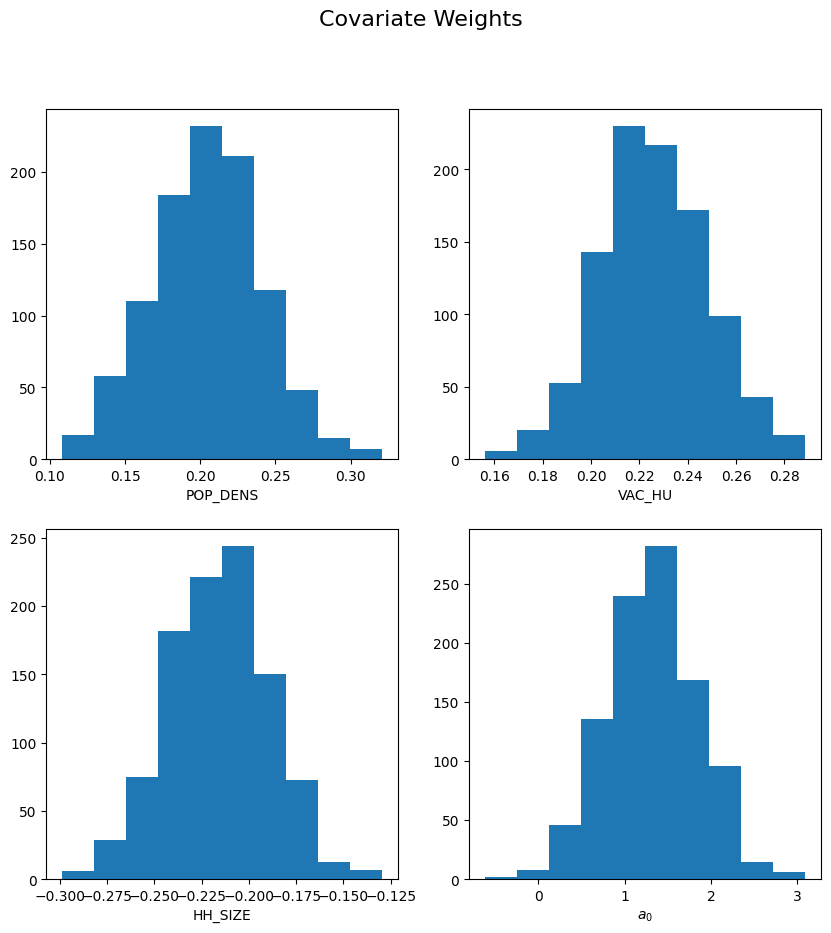

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,0.204632,0.035862,5.706130,1.155740e-08,0.135541,0.276523
VAC_HU,0.226003,0.022327,10.122266,0.000000e+00,0.182093,0.270407
HH_SIZE,-0.215782,0.026735,-8.071065,6.661338e-16,-0.267746,-0.165120
a_0,1.323295,0.533486,2.480470,1.312094e-02,0.298430,2.328461


In [6]:
model.cov_weight_post_summary()

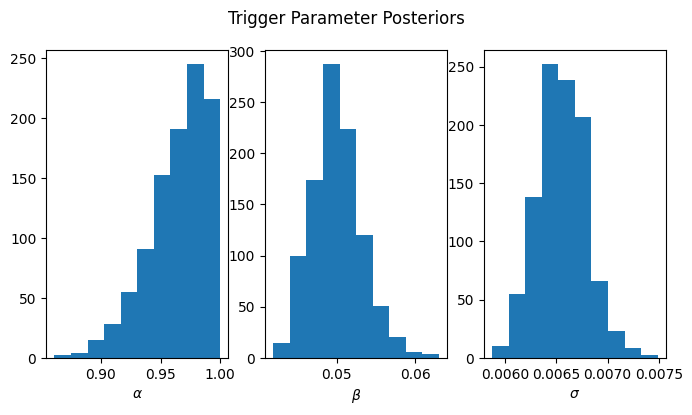

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.964699,0.025095,38.442585,0.0,0.904884,0.997991
beta,0.050053,0.003201,15.638444,0.0,0.044442,0.057049
sigma,0.006556,0.000239,27.436487,0.0,0.006098,0.007027


In [6]:
model.plot_trigger_posterior(f'output/Chicago_Shootings/{model_name}/trig_post.png')

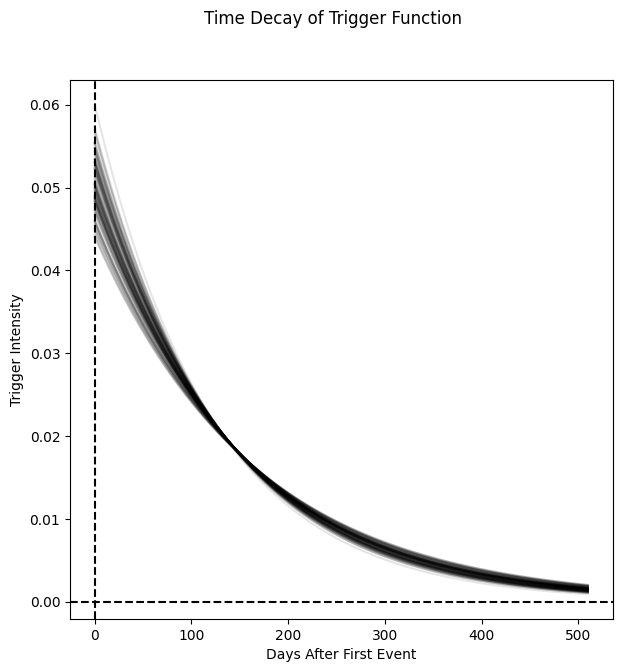

Mean trigger time: 145.67 days


In [8]:
model.plot_trigger_time_decay()

In [14]:
cir_mod = Point_Process_Model('data/Chicago/Crime_Incident_Reports/sr_2022_xyt.csv',A,model=model_name,
                            #spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:435: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  intersect = gpd.overlay(self.comp_grid, self.A, how='intersection')


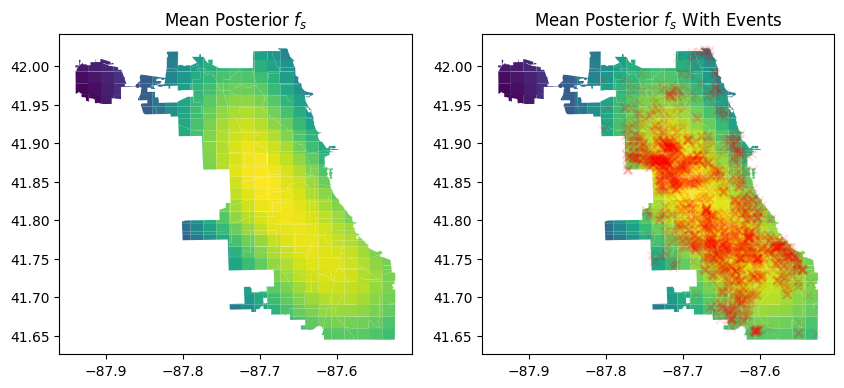

In [17]:
cir_mod.plot_spatial_background(alpha=.1)

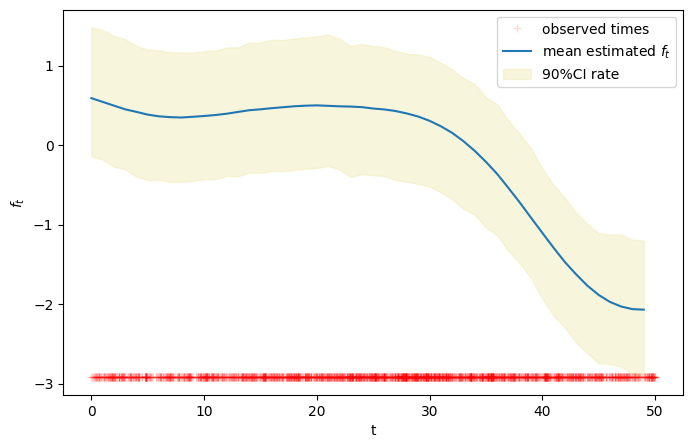

In [7]:
model.plot_temporal_background()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:435: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  intersect = gpd.overlay(self.comp_grid, self.A, how='intersection')


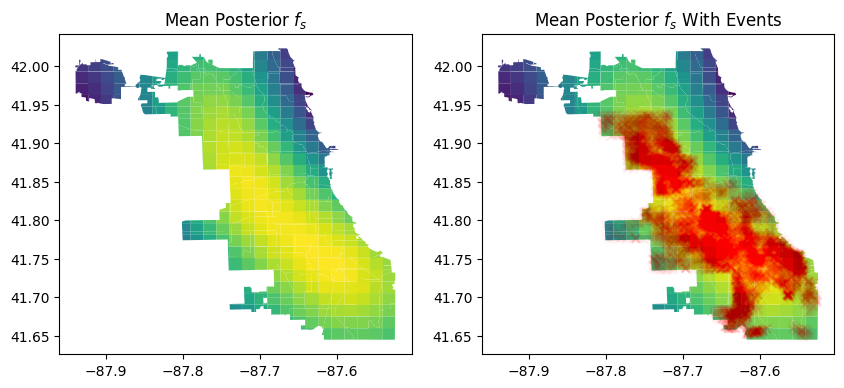

In [10]:
model.plot_spatial_background(alpha=.01)

In [ ]:
model.plot_temporal_background()

In [11]:
model.run_mcmc(output_file=f'output/Chicago_Shootings/{model_name}/output.pkl')

sample: 100%|█████████████████████████| 1500/1500 [1:06:53<00:00,  2.68s/it, 127 steps of size 4.22e-02. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -6.13      0.58     -6.12     -7.12     -5.21    332.34      1.00
         alpha      0.76      0.02      0.76      0.73      0.79   1205.13      1.00
          beta      0.13      0.01      0.13      0.11      0.14    930.20      1.00
      sigmax_2      0.00      0.00      0.00      0.00      0.00    741.71      1.00
          w[0]      2.17      0.09      2.16      2.00      2.31    599.49      1.00
          w[1]     -0.06      0.05     -0.06     -0.14      0.02    827.92      1.00
          w[2]     -2.83      0.06     -2.83     -2.94     -2.73    775.11      1.00
  z_spatial[0]     10.79      0.65     10.79      9.82     11.91    574.03      1.00
  z_spatial[1]     -4.04      0.48     -4.02     -4.85     -3.30    950.30      1.00
  z_spatial[2]     18.79      0.54     18.79     17.94     19.64    711.84      1.00
  z_spatial[3]     18.78      0.56     18.78     17.81     19.66

In [30]:
np.stack((model.spatial_cov.bounds.min(axis=0)[['minx','miny']],
          model.spatial_cov.bounds.max(axis=0)[['maxx','maxy']])).T

array([[-87.94011408, -87.5241371 ],
       [ 41.64454312,  42.02303859]])

In [ ]:
A = np.array([[-87.940114,-87.524137],
              [41.644543,42.023039]])

In [12]:
from bstpp.inference_functions import *
import pickle

output_dict = {}
output_dict['model']=spatiotemporal_hawkes_model
output_dict['samples']=model.mcmc_samples
output_dict['mcmc']=model.mcmc
with open(f'output/Chicago_Shootings/{model_name}/output.pkl', 'wb') as handle:
    pickle.dump(output_dict, handle)

In [3]:
import sys
from bstpp import inference_functions
from bstpp import utils
sys.modules['inference_functions'] = inference_functions
sys.modules['utils'] = utils

import pickle
pre_run = True
if pre_run:
    with open(f'output/Chicago_Shootings/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']

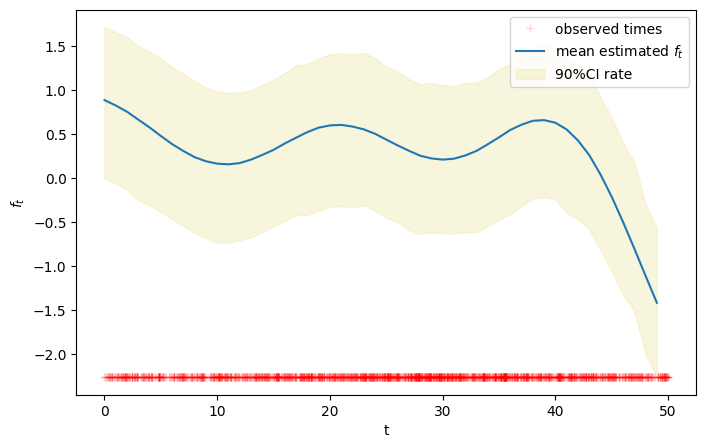

In [12]:
model.plot_temporal_background(f'output/Chicago_Shootings/{model_name}/temp_gp.png')

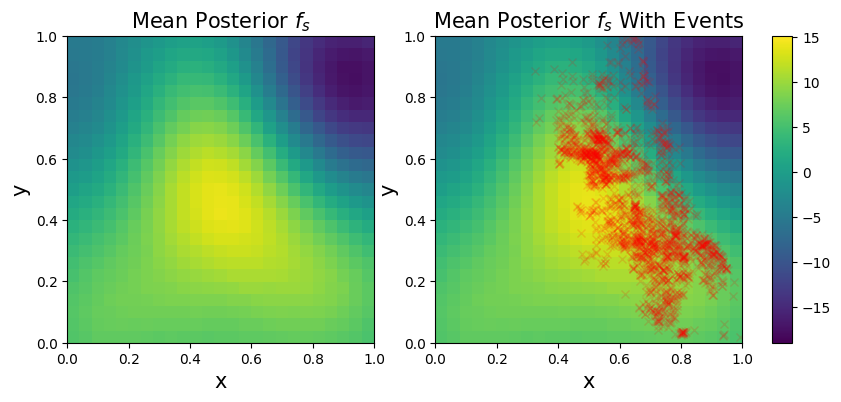

In [13]:
model.plot_spatial_background()

<AxesSubplot:>

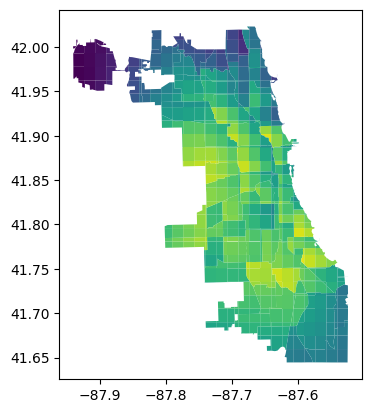

In [22]:
model.args['int_df']['post_mean_exp'] = np.exp(model.args['int_df']['post_mean'])
model.args['int_df'].plot(column='post_mean')

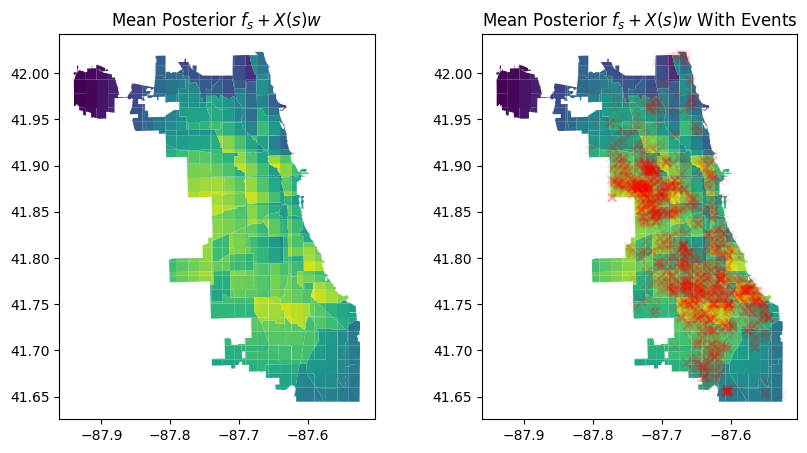

In [14]:
model.plot_spatial_background(f'output/Chicago_Shootings/{model_name}/spat_cov_gp.png',include_cov=True)

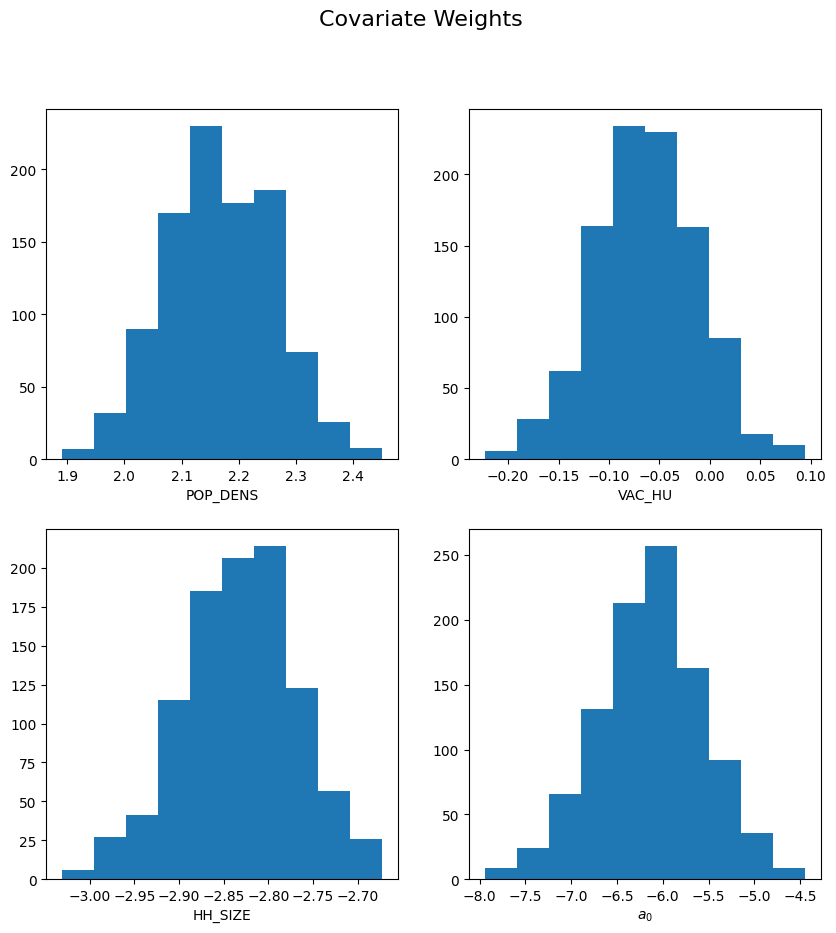

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,2.167948,0.094825,22.862608,0.000000,1.989814,2.350165
VAC_HU,-0.062866,0.051447,-1.221938,0.221731,-0.163786,0.033729
HH_SIZE,-2.831886,0.063915,-44.307373,0.000000,-2.964856,-2.707921
a_0,-6.130668,0.578547,-10.596660,0.000000,-7.325783,-4.950991


In [15]:
model.cov_weight_post_summary(plot_file=f'output/Chicago_Shootings/{model_name}/cov_post.png',
                              summary_file=f'output/Chicago_Shootings/{model_name}/cov_sum.csv'
                             )

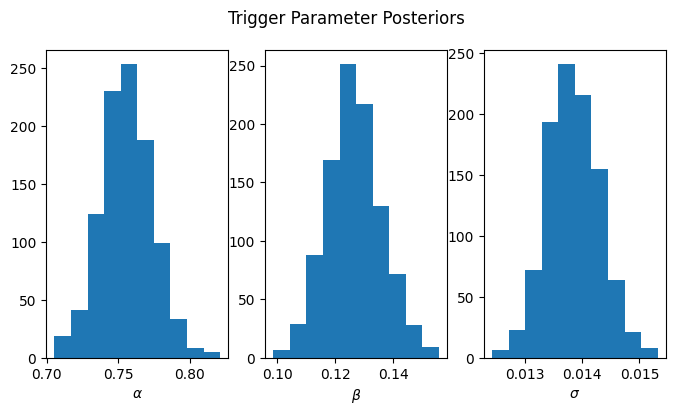

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.755952,0.018150,41.650097,0.0,0.720820,0.792177
beta,0.126411,0.009367,13.495183,0.0,0.108426,0.145183
sigma,0.013852,0.000458,30.264410,0.0,0.012979,0.014769


In [16]:
model.plot_trigger_posterior(f'output/Chicago_Shootings/{model_name}/trig_post.png')

In [19]:
0.01385/.4*110*0.621371

2.3666467962499995

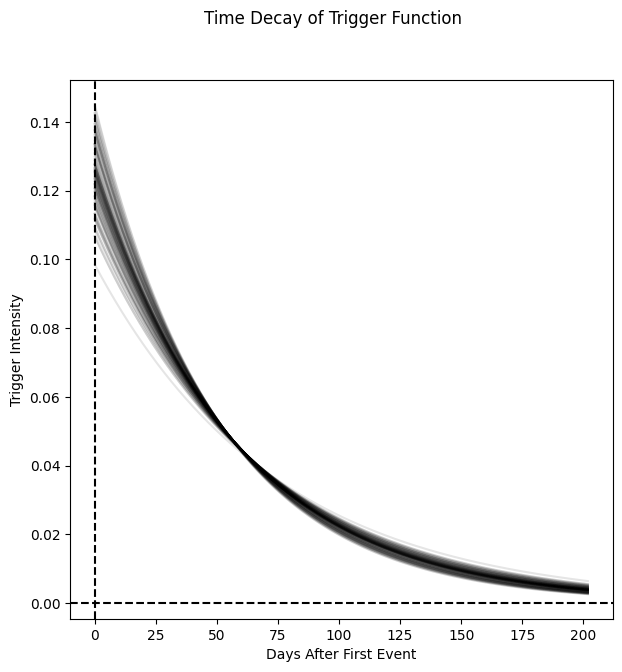

Mean trigger time: 57.68 days


In [17]:
model.plot_trigger_time_decay(f'output/Chicago_Shootings/{model_name}/trig_post_time_decay.png')

## Boko Haram Dataset

In [2]:
A = np.array([[3,15.5],[4,16.5]])
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
model_name = 'hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            spatial_cov='data/inc_spatial_cov.csv',cov_grid_size=(0.5,0.5),
                            cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

In [3]:
import sys
from bstpp import inference_functions
from bstpp import utils
sys.modules['inference_functions'] = inference_functions
sys.modules['utils'] = utils

import pickle
pre_run = True
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc(num_warmup=500,num_samples=1000,output_file=f'output/{model_name}/output.pkl')

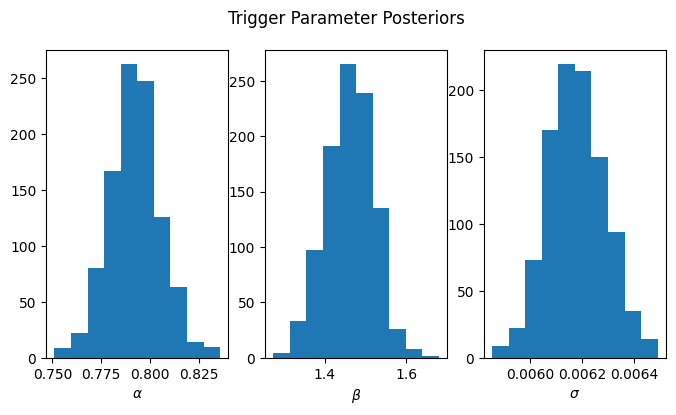

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.792135,0.013165,60.170200,0.0,0.766795,0.818655
beta,1.462121,0.057466,25.443113,0.0,1.348562,1.566254
sigma,0.006178,0.000109,56.548809,0.0,0.005972,0.006405


In [4]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

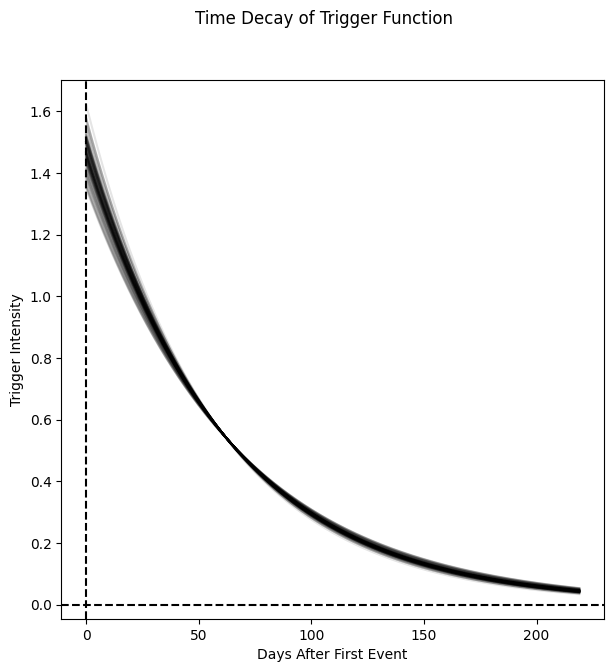

Mean trigger time: 62.57 days


In [5]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

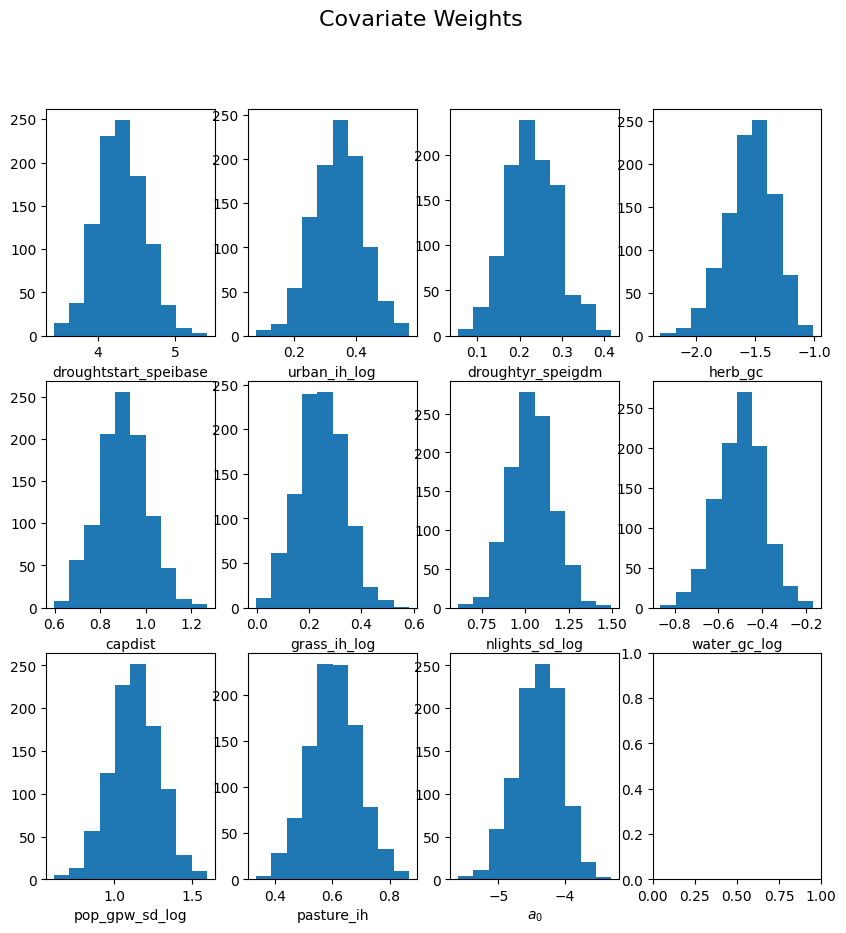

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,4.302984,0.305537,14.083326,0.000000e+00,3.705304,4.904547
urban_ih_log,0.342801,0.079758,4.298030,1.723228e-05,0.192258,0.501084
droughtyr_speigdm,0.230332,0.060860,3.784611,1.539488e-04,0.119518,0.355229
herb_gc,-1.539919,0.204606,-7.526260,5.218048e-14,-1.979717,-1.179485
capdist,0.901265,0.106708,8.446096,0.000000e+00,0.693985,1.115439
grass_ih_log,0.246746,0.088533,2.787050,5.319026e-03,0.072065,0.419774
nlights_sd_log,1.036318,0.124945,8.294169,1.110223e-16,0.805495,1.280154
water_gc_log,-0.497516,0.105864,-4.699586,2.606890e-06,-0.718159,-0.291534
pop_gpw_sd_log,1.132172,0.155079,7.300621,2.864375e-13,0.831008,1.425399
pasture_ih,0.606247,0.087623,6.918786,4.555356e-12,0.433513,0.782097


In [10]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

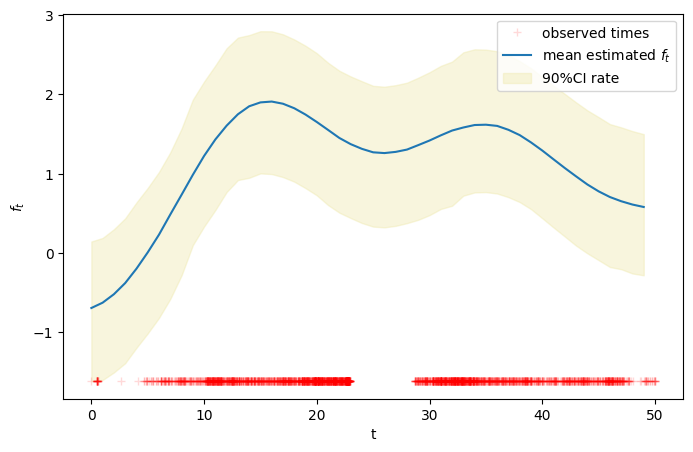

In [5]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

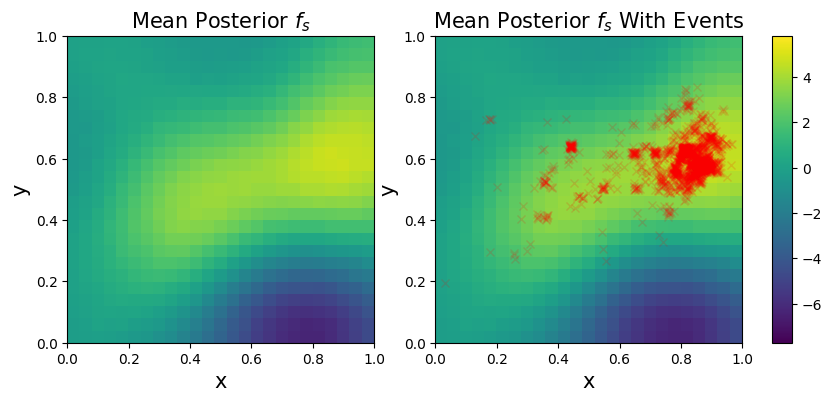

In [6]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

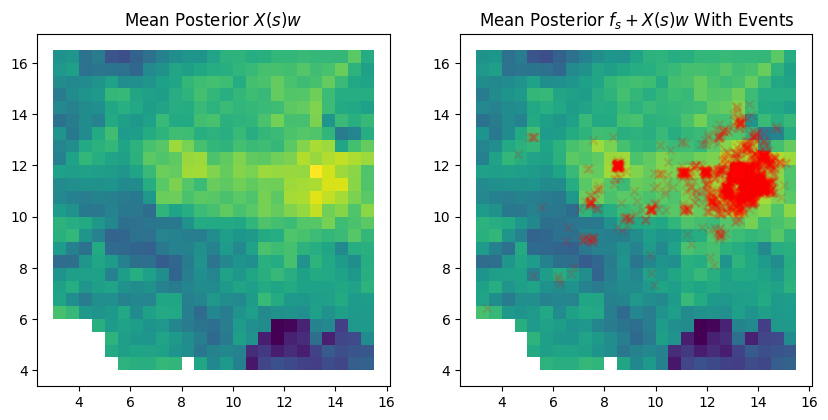

In [4]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)